In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, FloatSlider
from keras.models import Sequential, Model
from keras.layers import (Input, Lambda, concatenate, Dense)
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

In [16]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)
x_train -= x_train.min()
x_train = x_train/x_train.max()

In [17]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [18]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)


In [21]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [22]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
dec_x = dec_2(z)
x_hat = dec_1(dec_x)
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 100)          78500       input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 2)            202         dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 2)            202         dense_16[0][0]                   
__________________________________________________________________________________________________
lambda_5 (

In [24]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

VAE.compile(loss=vae_loss, optimizer=Adam())

In [25]:
VAE.fit(x_train, x_train, batch_size=999, epochs=9)

Instructions for updating:
Use tf.cast instead.
Epoch 1/9
60000/60000 [==============================] - 5s 91us/step - loss: 331.2712
Epoch 2/9
60000/60000 [==============================] - 5s 83us/step - loss: 223.1142
Epoch 3/9
60000/60000 [==============================] - 5s 92us/step - loss: 210.4387
Epoch 4/9
60000/60000 [==============================] - 5s 82us/step - loss: 204.1644
Epoch 5/9
60000/60000 [==============================] - 5s 83us/step - loss: 198.8470
Epoch 6/9
60000/60000 [==============================] - 5s 80us/step - loss: 194.8231
Epoch 7/9
60000/60000 [==============================] - 5s 84us/step - loss: 192.3330
Epoch 8/9
60000/60000 [==============================] - 5s 85us/step - loss: 190.4651
Epoch 9/9
60000/60000 [==============================] - 5s 76us/step - loss: 189.2436


In [26]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [28]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_20 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [34]:
idx = np.random.randint(x_train.shape[0])
indices = np.random.randint(x_test.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

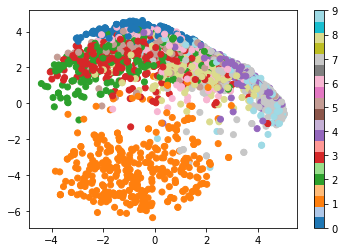

In [35]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

In [41]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [42]:
n=15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

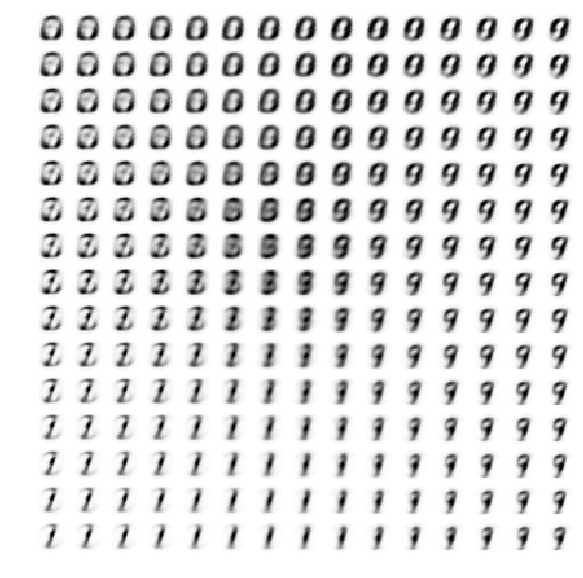

In [50]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [44]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [45]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [46]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>